# Impact of Covid Crowd Restrictions on Football Home Field Advantage
+ Original Study - [Home advantage dusing the COVID-19 pandenic: Analyses of European football leagues](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8422080/)
+ Data used in paper available at [OSF Storage location](https://osf.io/4hu8r/files/osfstorage?view_only=1176423f8b594ddbb0d93b5c45856557)
+ Data used in analysis scraped from `worldfootballR` R package

### Environment

In [1]:
env_filepath = !which python
env_filepath[0].split('envs/')[1].split('/')[0]

'bmcp'

### Imports

In [2]:
import os
import sys
import math
import warnings
from pathlib import Path

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import scipy.stats as stats
# from scipy.stats import norm, probplot
from scr.plots import quantiles, theoretical_qq, qq_quantiles, mean_diffs, pairwise_qq
from plotnine import *
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

# from scipy.stats import norm, probplot
from scratchpads.scr.plots import quantiles, theoretical_qq, qq_quantiles, mean_diffs, pairwise_qq

### Setup

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
SEED = 919

PROJECT_DIR = Path(os.environ['PROJECT_DIR'])
DATA_DIR = PROJECT_DIR / 'data'  #/ 'football' / 'osfstorage-archive' / 'Data' / 'Home AdvantageFinalDat.xlsx' 
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data')

# Background

+ Authors define Home Advantage as:
    + *The common way of quantifying the HA is to express the number of points (or goals) won at home as a percentage of the total number of points (goals) won, home and away (Pollard, 1986). This method has been previously validated (see Goumas, 2013) and works well with a full season of play where teams face each other at home and away.*
+ Authors run a multi level  (mixed effects) regression model on Points, goals, dominance (attacking metric). [Regression results](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8422080/table/tbl2/?report=objectonly), and similar analysis for fouls, yellow cards, red cards across main European leagues 2019-2020 season.
+ Regression factors:
    + Playing at home or away *Venue*
    + Covid Period ie match played with or without crowd
    + Rating Difference (538 SPI metric)
    + Importance difference (538 importance metric)
    + countries
    + league - top 2 leagues from each country used in analysis
+ Conclusions
    + *For team performance, our data clearly showed that when controlling for factors such as country, league, schedule, and team quality, the effect of playing in virtually empty stadia had a significant negative impact on the typical home team performance.*
    
## Alternate Analysis for Premier League for Goal Difference
 + Chapter 1 Bayesian stats for hackers has a time series model that could be adapted to run a much simpler analysis
     + Split the 2019-2020 season with a binary variable `is_covid`
         + Normal attendance during pre-covid period - `is_covid = 0`
         + No attendance during covid period - `is_covid = 1` 
 + Do not know how to do a bayesian multilevel regression yet, and the authors think it is important to control for other factors such as schedule strength, match importance when comparing pre-covid to covid. However, it may be possible to get an idea of the impact of other factors by running the same analysis on non covid seasons ie. 2017-2018 and 2018-2019. This may give an idea as to any typical shift in home field advatage due to non-covid related factors.
 + xg data only available from 2017-2018 season, so data used from:
     + 2017 - 2018
     + 2018 - 2019
     + 2019 - 2020
     seasons data
+ Goal difference = home team goals - away team goals
+ Other HFA Links
    + https://www.smithsonianmag.com/smart-news/homefield-advantage-falls-ill-during-covid-19-180978475/
    + https://www.frontiersin.org/articles/10.3389/fpsyg.2021.658452/full

In [4]:
df_orig = pd.read_csv(DATA_DIR / 'football' / 'ENG-results.csv', parse_dates=['date']).drop(columns=['Unnamed: 0'])
df_orig.head()

,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,attendance,season-key,match-key,fthg,ftag,psch,pscd,psca,maxch,maxcd,maxca,maxh,maxd,maxa,avgh,avgd,avga,xgdiff,goaldiff,goalresult,xgresult,pc(hwin),pc(draw),pc(awin),pmxc(hwin),pmxc(draw),pmxc(awin)
0,1,2016-08-13,15:00,Burnley,0.0,NaN,Swansea-City,1.0,NaN,19126.0,english-premier-league-2017,english-premier-league-2017-0,0.0,1.0,2.79,3.16,2.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,awin,NaN,0.351085,0.309977,0.338937,NaN,NaN,NaN
1,1,2016-08-13,15:00,Crystal-Palace,0.0,NaN,West-Brom,1.0,NaN,24490.0,english-premier-league-2017,english-premier-league-2017-1,0.0,1.0,2.25,3.15,3.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,awin,NaN,0.435315,0.310939,0.253746,NaN,NaN,NaN
2,1,2016-08-13,15:00,Everton,1.0,NaN,Tottenham,1.0,NaN,39494.0,english-premier-league-2017,english-premier-league-2017-2,1.0,1.0,3.64,3.54,2.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,draw,NaN,0.269293,0.276900,0.453808,NaN,NaN,NaN
3,1,2016-08-13,12:30,Hull-City,2.0,NaN,Leicester-City,1.0,NaN,21037.0,english-premier-league-2017,english-premier-league-2017-3,2.0,1.0,4.68,3.50,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,hwin,NaN,0.209440,0.280051,0.510509,NaN,NaN,NaN
4,1,2016-08-13,17:30,Manchester-City,2.0,NaN,Sunderland,1.0,NaN,54362.0,english-premier-league-2017,english-premier-league-2017-4,2.0,1.0,1.25,6.50,14.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,hwin,NaN,0.782158,0.150415,0.067427,NaN,NaN,NaN


### Data

In [5]:
df_orig = pd.read_csv(DATA_DIR / 'football' / 'ENG-results.csv', parse_dates=['date']).drop(columns=['Unnamed: 0'])
keepers = ['wk', 'date', 'time', 'h', 'h_ftgoals', 'h_xg', 'a', 'a_ftgoals', 'a_xg', 'attendance', 'season_key', 
          'pc(hwin)', 'pc(draw)', 'pc(awin)']
# df_orig = df_orig.sort_values(by=['date', 'time', 'h']).reset_index(drop=True)
df_orig['season_key'] = ((df_orig['season-key'].str.split('-',3).str[3].astype(int) -1).astype(str) + '-' +
                         df_orig['season-key'].str.split('-',3).str[3])
df_orig = df_orig.drop(columns=['season-key'])

season_order = ['2017-2018', '2018-2019', '2019-2020']
cat_type=CategoricalDtype(categories=season_order, ordered=True)
df_orig['season_key'] = df_orig['season_key'].astype(cat_type)

df_orig['attendance'] = df_orig['attendance'].fillna(0)
df_orig = df_orig[keepers]
seasons = ('2017-2018', '2018-2019', '2019-2020')
df_orig = df_orig[df_orig['season_key'].isin(seasons)]
df_orig = df_orig.sort_values(by=['date', 'time', 'h']).reset_index(drop=True).reset_index()

condlist = [df_orig['h_ftgoals'] > df_orig['a_ftgoals'],
            df_orig['h_ftgoals'] == df_orig['a_ftgoals'],
            df_orig['h_ftgoals'] < df_orig['a_ftgoals']]
choicelist = ['hwin', 'draw', 'awin']
df_orig['result'] = np.select(condlist, choicelist)
df_orig['h_points'] = df_orig['result'].map({'hwin': 3, 'draw': 1, 'awin': 0})
df_orig['a_points'] = df_orig['result'].map({'hwin': 0, 'draw': 1, 'awin': 3})


# The last 92 games of the 2019-2020 season were played with no fans in the grounds
# There are 380 games in a season
# Setup a binary variable in each season to reflect this proportion
df_orig['is_covid'] = ([0]*(380-92) + [1] * 92) * 3
df_orig['is_covid'] = df_orig['is_covid'].astype('category')
# Make another category, so we can look inside particular seasons
df_orig['season_split'] = df_orig['season_key'].astype(str) + '_' + df_orig['is_covid'].astype(str)
df_orig['season_split'] = df_orig['season_split'].astype('category')

df_orig.head()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,attendance,season_key,pc(hwin),pc(draw),pc(awin),result,h_points,a_points,is_covid,season_split
0,0,1,2017-08-11,19:45,Arsenal,4.0,2.5,Leicester-City,3.0,1.5,59387.0,2017-2018,0.657666,0.207172,0.135162,hwin,3,0,0,2017-2018_0
1,1,1,2017-08-12,12:30,Watford,3.0,2.1,Liverpool,3.0,2.6,20407.0,2017-2018,0.142420,0.229473,0.628108,draw,1,1,0,2017-2018_0
2,2,1,2017-08-12,15:00,Chelsea,2.0,1.5,Burnley,3.0,0.6,41616.0,2017-2018,0.738079,0.181786,0.080134,awin,0,3,0,2017-2018_0
3,3,1,2017-08-12,15:00,Crystal-Palace,0.0,1.1,Huddersfield,3.0,1.5,25448.0,2017-2018,0.547144,0.275109,0.177747,awin,0,3,0,2017-2018_0
4,4,1,2017-08-12,15:00,Everton,1.0,0.6,Stoke-City,0.0,0.4,39045.0,2017-2018,0.538421,0.280781,0.180798,hwin,3,0,0,2017-2018_0


### Calculated Values for Home Field Advantage

In [6]:
# Based on definition in reference paper and calculated per game
df_orig['ha_xg'] = df_orig['h_xg'] / df_orig[['h_xg', 'a_xg']].sum(axis=1)
df_orig['ha_xg2'] = (df_orig['h_xg'] - df_orig['a_xg']) / df_orig[['h_xg', 'a_xg']].sum(axis=1)
df_orig['ha_points'] = df_orig['h_points'] / df_orig[['h_points', 'a_points']].sum(axis=1)
# This calc can give a divide by zer0, so replace NaNs with zero
df_orig['ha_goals'] = df_orig['h_ftgoals'] / df_orig[['h_ftgoals', 'a_ftgoals']].sum(axis=1)
df_orig['ha_goals'] = df_orig['ha_goals'].fillna(0)
# Some simpler measures for HFA based on difference ie home metric - away metric
df_orig['xg_diff'] = df_orig['h_xg'] - df_orig['a_xg']
df_orig['points_diff'] = df_orig['h_points'] - df_orig['a_points']
df_orig['goal_diff'] = df_orig['h_ftgoals'] - df_orig['a_ftgoals']
df_orig.head()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,attendance,season_key,pc(hwin),pc(draw),pc(awin),result,h_points,a_points,is_covid,season_split,ha_xg,ha_xg2,ha_points,ha_goals,xg_diff,points_diff,goal_diff
0,0,1,2017-08-11,19:45,Arsenal,4.0,2.5,Leicester-City,3.0,1.5,59387.0,2017-2018,0.657666,0.207172,0.135162,hwin,3,0,0,2017-2018_0,0.625000,0.250000,1.0,0.571429,1.0,3,1.0
1,1,1,2017-08-12,12:30,Watford,3.0,2.1,Liverpool,3.0,2.6,20407.0,2017-2018,0.142420,0.229473,0.628108,draw,1,1,0,2017-2018_0,0.446809,-0.106383,0.5,0.500000,-0.5,0,0.0
2,2,1,2017-08-12,15:00,Chelsea,2.0,1.5,Burnley,3.0,0.6,41616.0,2017-2018,0.738079,0.181786,0.080134,awin,0,3,0,2017-2018_0,0.714286,0.428571,0.0,0.400000,0.9,-3,-1.0
3,3,1,2017-08-12,15:00,Crystal-Palace,0.0,1.1,Huddersfield,3.0,1.5,25448.0,2017-2018,0.547144,0.275109,0.177747,awin,0,3,0,2017-2018_0,0.423077,-0.153846,0.0,0.000000,-0.4,-3,-3.0
4,4,1,2017-08-12,15:00,Everton,1.0,0.6,Stoke-City,0.0,0.4,39045.0,2017-2018,0.538421,0.280781,0.180798,hwin,3,0,0,2017-2018_0,0.600000,0.200000,1.0,1.000000,0.2,3,1.0


In [7]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         1140 non-null   int64         
 1   wk            1140 non-null   int64         
 2   date          1140 non-null   datetime64[ns]
 3   time          1140 non-null   object        
 4   h             1140 non-null   object        
 5   h_ftgoals     1140 non-null   float64       
 6   h_xg          1140 non-null   float64       
 7   a             1140 non-null   object        
 8   a_ftgoals     1140 non-null   float64       
 9   a_xg          1140 non-null   float64       
 10  attendance    1140 non-null   float64       
 11  season_key    1140 non-null   category      
 12  pc(hwin)      1140 non-null   float64       
 13  pc(draw)      1140 non-null   float64       
 14  pc(awin)      1140 non-null   float64       
 15  result        1140 non-null   object  

In [8]:
df_orig.describe()

,index,wk,h_ftgoals,h_xg,a_ftgoals,a_xg,attendance,pc(hwin),pc(draw),pc(awin),h_points,a_points,ha_xg,ha_xg2,ha_points,ha_goals,xg_diff,points_diff,goal_diff
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,569.500000,19.500000,1.538596,1.462456,1.201754,1.177632,35417.034211,0.443898,0.240515,0.315587,1.614035,1.156140,0.549062,0.098123,0.576316,0.528461,0.284825,0.457895,0.336842
std,329.233959,10.970669,1.300132,0.824841,1.185809,0.733519,19337.834358,0.214517,0.061883,0.196115,1.333757,1.293669,0.220180,0.440360,0.432300,0.370879,1.249178,2.593803,1.911256
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037577,0.051976,0.023453,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-4.300000,-3.000000,-9.000000
25%,284.750000,10.000000,1.000000,0.800000,0.000000,0.600000,23555.500000,0.292945,0.204138,0.169571,0.000000,0.000000,0.388889,-0.222222,0.000000,0.250000,-0.500000,-3.000000,-1.000000
50%,569.500000,19.500000,1.000000,1.300000,1.000000,1.100000,31380.000000,0.422247,0.261205,0.285549,1.000000,1.000000,0.554094,0.108187,0.500000,0.500000,0.200000,0.000000,0.000000
75%,854.250000,29.000000,2.000000,2.000000,2.000000,1.600000,53172.750000,0.585494,0.286611,0.417274,3.000000,3.000000,0.724138,0.448276,1.000000,1.000000,1.100000,3.000000,2.000000
max,1139.000000,38.000000,8.000000,5.900000,9.000000,4.600000,83222.000000,0.924572,0.338988,0.890472,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,5.500000,3.000000,8.000000


# Attendance

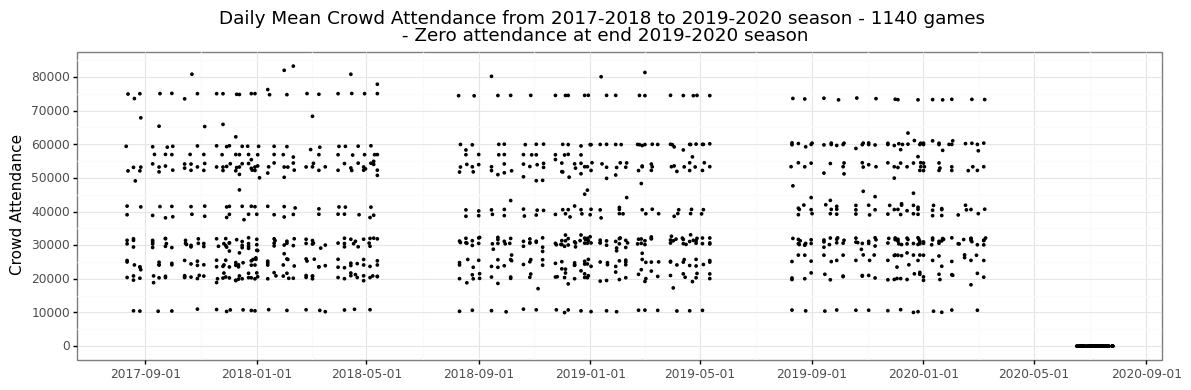

In [9]:
df1 = df_orig.copy()
p = (ggplot(df1, aes(x='date', y='attendance')) +
     geom_point(size=0.5) +
     # stat_summary(fun_y=np.mean, geom="point") +
     scale_y_continuous(breaks=np.linspace(0, 100000, 11)) +
     ylab('Crowd Attendance') +
     xlab('') +
     labs(title=f'Daily Mean Crowd Attendance from 2017-2018 to 2019-2020 season - {len(df1)} games\n - Zero attendance at end 2019-2020 season') +
     theme(figure_size=(14, 4))
    )
p.draw();

In [10]:
print(f'number of covid - 0 attendance matches: {(df1["attendance"]==0).sum()}')

number of covid - 0 attendance matches: 92


# Goal Difference

In [11]:
target_metric = 'goal_diff'

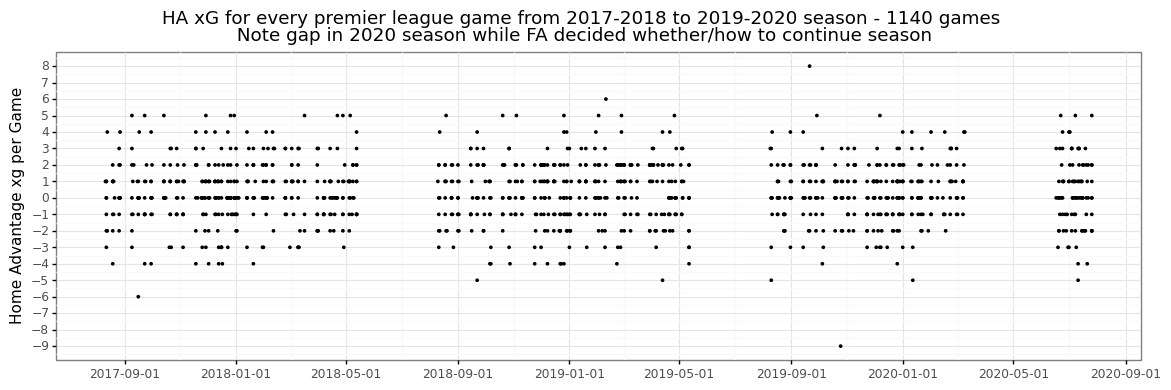

In [12]:
df1 = df_orig.copy()
p = (ggplot(df1, aes(x='date', y=target_metric)) +
     geom_point(size=0.5) +
     scale_y_continuous(breaks=np.linspace(-10, 10, 21)) +
     ylab('Home Advantage xg per Game') +
     xlab('') +
     labs(title=f'HA xG for every premier league game from 2017-2018 to 2019-2020 season - {len(df1)} games\n Note gap in 2020 season while FA decided whether/how to continue season') +
     theme(figure_size=(14, 4))
    )
p.draw();

## Can the Normal Distribution be used to model the data?

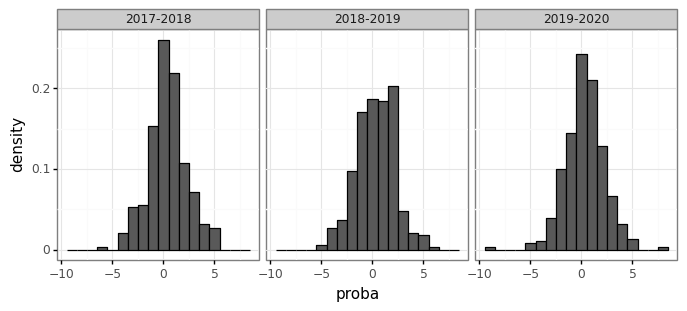

In [13]:
# df_2017[y] = stats.boxcox(df_2017[y].values, 1.5)
binwidth = 1.0
p = (ggplot(df_orig, aes(x=target_metric, y=after_stat('density'), group='season_key')) +
     geom_histogram(binwidth=binwidth, color='black') +
     facet_wrap(facets='season_key', nrow=1, ncol=3) +
     xlab('proba') +
     theme(figure_size=(8, 3))
    )
p.draw();

In [14]:
qq_norms = theoretical_qq(df_orig, 'season_key', target_metric, dist='norm')
qq_norms.head()

,season_key,theory_quantiles,goal_diff,slope,intercept
0,2017-2018,-2.907370,-6.0,1.872685,0.384211
1,2017-2018,-2.617920,-4.0,1.872685,0.384211
2,2017-2018,-2.454581,-4.0,1.872685,0.384211
3,2017-2018,-2.338468,-4.0,1.872685,0.384211
4,2017-2018,-2.247296,-4.0,1.872685,0.384211


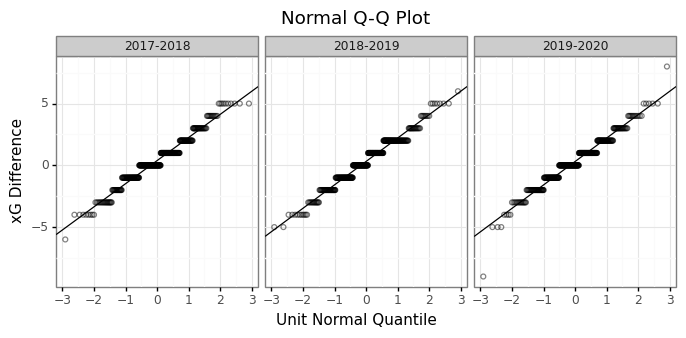

In [15]:
p = (ggplot(qq_norms, aes(x='theory_quantiles', y=target_metric)) +
     geom_point(fill='none', alpha=0.5) +
     geom_abline(aes(intercept='intercept', slope='slope', alpha=0.5)) +
     labs(title="Normal Q-Q Plot",
          caption='2.1 Normal q-q plots compare\nthe eight height distributions with\nthe normal distribution.') +
     theme_bw() + 
     xlab("Unit Normal Quantile") + 
     ylab("xG Difference") +
     facet_wrap('season_key', ncol=3, as_table=False) +
     theme(legend_position='none') +
     theme(figure_size=(8, 3))
    )
p.draw();

## Simulate in-season mean Goal Difference Shifts

In [16]:
qq_norms[['season_key', 'slope', 'intercept']].value_counts()

season_key  slope     intercept
2017-2018   1.872685  0.384211     380
2018-2019   1.896811  0.315789     380
2019-2020   1.898153  0.310526     380
dtype: int64

In [17]:
qq_norms_norm = qq_norms.copy()
qq_norms_norm = qq_norms_norm[qq_norms_norm['season_key'].isin(('2017-2018', '2018-2019'))]
qq_norms_norm = qq_norms_norm[['season_key', 'slope', 'intercept']].value_counts().reset_index().rename(columns={0: 'n_games'})
qq_norms_norm

,season_key,slope,intercept,n_games
0,2017-2018,1.872685,0.384211,380
1,2018-2019,1.896811,0.315789,380


In [18]:
params = qq_norms_norm[['slope', 'intercept']].mean()
params

slope        1.884748
intercept    0.350000
dtype: float64

In [19]:
def make_shifted_season(n_before, n_total, params, shift=0.0):
    # Put shift i.t.o sigmas
    shift = shift * params[0]
    before_shift_sample = stats.norm.rvs(loc=params[1], scale=params[0], size=(n_before))
    after_shift_sample = stats.norm.rvs(loc=params[1] + shift, scale=params[0], size=(n_total - n_before))
    shifted_season = pd.DataFrame({target_metric: np.hstack([before_shift_sample, after_shift_sample]),
                                   'is_shift': np.hstack([[0]*n_before, [1]*(n_total - n_before)]),
                                   'shift': np.hstack([[0]*n_before, [shift]*(n_total - n_before)])}).reset_index()
    
    return shifted_season
seas = make_shifted_season(288, 380, params, shift=-0.3)
seas

,index,goal_diff,is_shift,shift
0,0,1.156689,0,0.000000
1,1,0.549026,0,0.000000
2,2,0.204400,0,0.000000
3,3,4.226630,0,0.000000
4,4,1.092194,0,0.000000
...,...,...,...,...
375,375,-1.801115,1,-0.565424
376,376,0.455444,1,-0.565424
377,377,1.633627,1,-0.565424
378,378,1.866378,1,-0.565424


In [20]:
print(seas)

     index  goal_diff  is_shift     shift
0        0   1.156689         0  0.000000
1        1   0.549026         0  0.000000
2        2   0.204400         0  0.000000
3        3   4.226630         0  0.000000
4        4   1.092194         0  0.000000
..     ...        ...       ...       ...
375    375  -1.801115         1 -0.565424
376    376   0.455444         1 -0.565424
377    377   1.633627         1 -0.565424
378    378   1.866378         1 -0.565424
379    379  -2.707265         1 -0.565424

[380 rows x 4 columns]


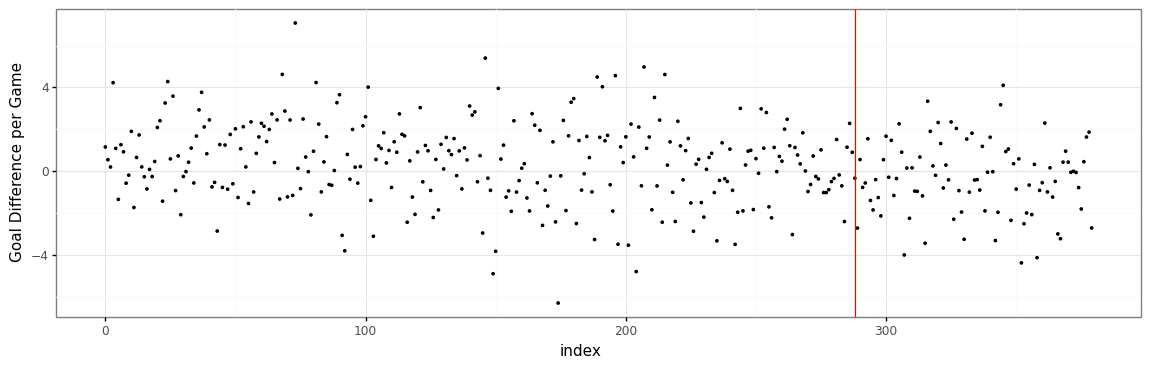

In [21]:
p = (ggplot(seas, aes(x='index', y=target_metric)) +
     geom_point(size=0.5) +
     geom_vline(xintercept=288, color='red') +
     ylab('Goal Difference per Game') +
     theme(figure_size=(14, 4))
    )
p.draw();

In [22]:
shifted_seasons = []
for idx, shift in enumerate(np.linspace(0.0, 0.9, 10)):
    print(shift)
    shifted_season = make_shifted_season(288, 380, params, shift=shift)
    shifted_season['idx'] = idx
    shifted_seasons.append(shifted_season)
all_shifted_seasons = pd.concat(shifted_seasons, axis=0)
all_shifted_seasons['idx_is_shift'] = all_shifted_seasons['idx'].astype(str) + '_' + all_shifted_seasons['is_shift'].astype(str) 
all_shifted_seasons['idx_is_shift'] = all_shifted_seasons['idx_is_shift'].astype('category')
all_shifted_seasons#.head()

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


,index,goal_diff,is_shift,shift,idx,idx_is_shift
0,0,0.504680,0,0.000000,0,0_0
1,1,0.073176,0,0.000000,0,0_0
2,2,0.210583,0,0.000000,0,0_0
3,3,0.389002,0,0.000000,0,0_0
4,4,-0.502991,0,0.000000,0,0_0
...,...,...,...,...,...,...
375,375,5.345084,1,1.696273,9,9_1
376,376,-0.666892,1,1.696273,9,9_1
377,377,1.070044,1,1.696273,9,9_1
378,378,0.987249,1,1.696273,9,9_1


In [23]:
qq_pairs = pairwise_qq(all_shifted_seasons, 'idx_is_shift', target_metric)
qq_pairs

,col_vals,row_vals,row,col
0,-4.245765,-3.846390,0_0,0_1
1,-3.706459,-3.537183,0_0,0_1
2,-3.287579,-2.998536,0_0,0_1
3,-3.278190,-2.879810,0_0,0_1
4,-2.737337,-2.664147,0_0,0_1
...,...,...,...,...
26295,5.867460,3.415840,9_0,9_1
26296,6.088503,3.474641,9_0,9_1
26297,6.339112,4.051018,9_0,9_1
26298,7.021727,4.218229,9_0,9_1


In [24]:
pairs = pd.DataFrame([('0_0', '0_1'), ('1_0', '1_1'), ('2_0', '2_1'), ('3_0', '3_1'), ('4_0', '4_1'), ('5_0', '5_1'),
                      ('6_0', '6_1'), ('7_0', '7_1'), ('8_0', '8_1'), ('9_0', '9_1')])
pairs.columns = ['row', 'col']
pairs_df = pairs.merge(right=qq_pairs, on=['row', 'col'], how='left')
pairs_df['season'] = pairs_df['row'].str.split('_').str[0]
# pairs_dfs = []
# for pair in pairs:
#     qq_pairs.groupby(by=pair
pairs_df

,row,col,col_vals,row_vals,season
0,0_0,0_1,-4.245765,-3.846390,0
1,0_0,0_1,-3.706459,-3.537183,0
2,0_0,0_1,-3.287579,-2.998536,0
3,0_0,0_1,-3.278190,-2.879810,0
4,0_0,0_1,-2.737337,-2.664147,0
...,...,...,...,...,...
915,9_0,9_1,5.867460,3.415840,9
916,9_0,9_1,6.088503,3.474641,9
917,9_0,9_1,6.339112,4.051018,9
918,9_0,9_1,7.021727,4.218229,9


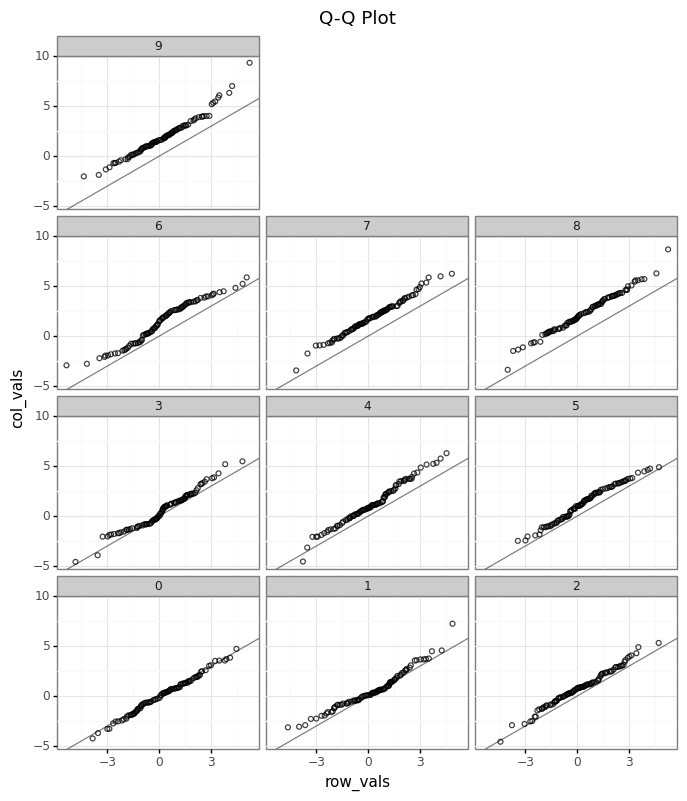

In [25]:
p = (ggplot(pairs_df, aes(x='row_vals', y='col_vals')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(intercept=0, slope=1, alpha=0.5) +
     # coord_cartesian(xlim=(qq.min().min(), qq.max().max()), ylim=(qq.min().min(), qq.max().max())) +  
     # xlab("none") +
     # ylab("Bass 2 height (inches)") +
     labs(title="Q-Q Plot",
           caption='2.5 The height distributions are compared by q-q plots for all pairs of singer voice parts.') +
     theme_bw() +
     # theme(axis.title.x=element_blank()) +
     # labs(x="Height (inches)") + 
     # labs(y="Height (inches)") +
     facet_wrap('season', ncol=3, as_table=False) +
     theme(figure_size=(8,9)))

p.draw();

## What is the shift in Distribution between the last 92 games and the earlier games?

In [26]:
qq_pairs = pairwise_qq(df_orig, 'season_split', target_metric)
qq_pairs.head()

,col_vals,row_vals,row,col
0,-3.0,-4.0,2017-2018_0,2017-2018_1
1,-3.0,-4.0,2017-2018_0,2017-2018_1
2,-3.0,-4.0,2017-2018_0,2017-2018_1
3,-3.0,-3.0,2017-2018_0,2017-2018_1
4,-2.0,-3.0,2017-2018_0,2017-2018_1


In [27]:
pairs = pd.DataFrame([('2017-2018_0', '2017-2018_1'), ('2018-2019_0', '2018-2019_1'), ('2019-2020_0', '2019-2020_1')])
pairs.columns = ['row', 'col']
pairs_df = pairs.merge(right=qq_pairs, on=['row', 'col'], how='left')
pairs_df['season'] = pairs_df['row'].str.split('_').str[0]
# pairs_dfs = []
# for pair in pairs:
#     qq_pairs.groupby(by=pair
pairs_df

,row,col,col_vals,row_vals,season
0,2017-2018_0,2017-2018_1,-3.0,-4.0,2017-2018
1,2017-2018_0,2017-2018_1,-3.0,-4.0,2017-2018
2,2017-2018_0,2017-2018_1,-3.0,-4.0,2017-2018
3,2017-2018_0,2017-2018_1,-3.0,-3.0,2017-2018
4,2017-2018_0,2017-2018_1,-2.0,-3.0,2017-2018
...,...,...,...,...,...
271,2019-2020_0,2019-2020_1,4.0,3.0,2019-2020
272,2019-2020_0,2019-2020_1,4.0,4.0,2019-2020
273,2019-2020_0,2019-2020_1,5.0,4.0,2019-2020
274,2019-2020_0,2019-2020_1,5.0,4.0,2019-2020


In [28]:
pairs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 275
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row       276 non-null    object 
 1   col       276 non-null    object 
 2   col_vals  276 non-null    float64
 3   row_vals  276 non-null    float64
 4   season    276 non-null    object 
dtypes: float64(2), object(3)
memory usage: 12.9+ KB


In [29]:
qq_pairs.tail()

,col_vals,row_vals,row,col
1963,4.0,3.0,2019-2020_0,2019-2020_1
1964,4.0,4.0,2019-2020_0,2019-2020_1
1965,5.0,4.0,2019-2020_0,2019-2020_1
1966,5.0,4.0,2019-2020_0,2019-2020_1
1967,5.0,5.0,2019-2020_0,2019-2020_1


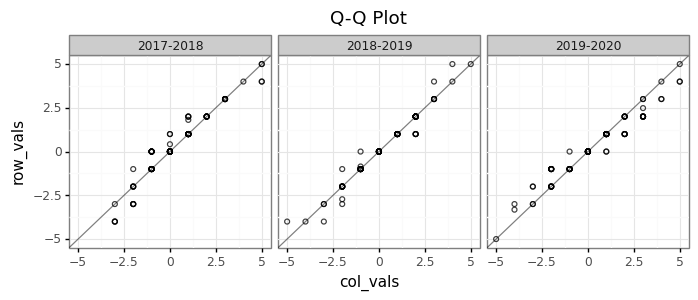

In [30]:
p = (ggplot(pairs_df, aes(x='col_vals', y='row_vals')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(intercept=0, slope=1, alpha=0.5) +
     # coord_cartesian(xlim=(qq.min().min(), qq.max().max()), ylim=(qq.min().min(), qq.max().max())) +  
     # xlab("none") +
     # ylab("Bass 2 height (inches)") +
     labs(title="Q-Q Plot",
           caption='2.5 The height distributions are compared by q-q plots for all pairs of singer voice parts.') +
     theme_bw() +
     # theme(axis.title.x=element_blank()) +
     # labs(x="Height (inches)") + 
     # labs(y="Height (inches)") +
     facet_wrap('season', as_table=True) +
     theme(figure_size=(8,2.5)))

p.draw();

In [31]:
# pairs_df
md = mean_diffs(pairs_df[['col_vals', 'row_vals']].copy())
md['season'] = pairs_df['season']
md
# # md = mean_diffs(pairs_df)
# md.head()

,col_vals,row_vals,mean,diff,season
0,-3.0,-4.0,-3.5,-1.0,2017-2018
1,-3.0,-4.0,-3.5,-1.0,2017-2018
2,-3.0,-4.0,-3.5,-1.0,2017-2018
3,-3.0,-3.0,-3.0,0.0,2017-2018
4,-2.0,-3.0,-2.5,-1.0,2017-2018
...,...,...,...,...,...
271,4.0,3.0,3.5,-1.0,2019-2020
272,4.0,4.0,4.0,0.0,2019-2020
273,5.0,4.0,4.5,-1.0,2019-2020
274,5.0,4.0,4.5,-1.0,2019-2020


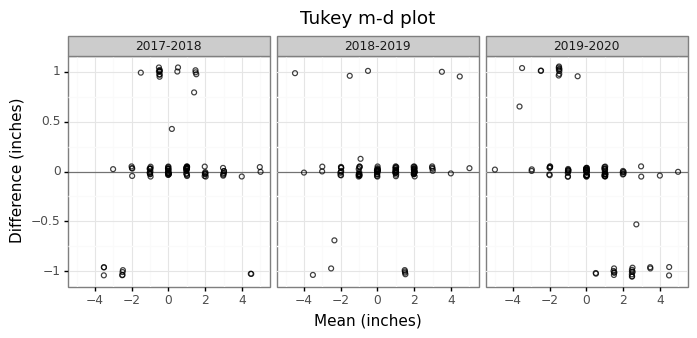

In [32]:


p = (ggplot(md, aes(x='mean', y='diff')) +
     geom_jitter(fill='none', alpha=0.75) +
     geom_abline(intercept=0, slope=0, alpha=0.5) +
     # geom_abline(intercept=md['diff'].mean(), slope=0, alpha=0.3, color='red') +
     scale_x_continuous(breaks=np.arange(math.floor(md['mean'].min()-1), math.ceil(md['mean'].max()), 2)) +
     facet_wrap('season') +
     xlab("Mean (inches)") +
     ylab("Difference (inches)") +
     labs(title="Tukey m-d plot",
          caption='2.4 The first tenor and second bass\nheight distributions are compared by\na Tukey m-d plot.') +
     theme_bw() +
     theme(figure_size=(8,3)))
p.draw();



## What is the shift between the last 92 games of non covid seasons and the covid season?

In [33]:
pairs2 = pd.DataFrame([('2017-2018_1', '2019-2020_1'), ('2018-2019_1', '2019-2020_1')])
# pairs2 = pd.DataFrame([('2017-2018_1', '2018-2019_1'), ('2017-2018_1', '2019-2020_1'), ('2018-2019_1', '2019-2020_1')])
pairs2.columns = ['row', 'col']
pairs_df2 = pairs2.merge(right=qq_pairs, on=['row', 'col'], how='left')
pairs_df2['season'] = pairs_df2['row'].str.split('_').str[0]
# pairs_df2['season'] = pairs_df2['row']
# pairs_dfs = []
# for pair in pairs:
#     qq_pairs.groupby(by=pair
pairs_df2

,row,col,col_vals,row_vals,season
0,2017-2018_1,2019-2020_1,-4.505435,-3.0,2017-2018
1,2017-2018_1,2019-2020_1,-4.000000,-3.0,2017-2018
2,2017-2018_1,2019-2020_1,-3.527174,-3.0,2017-2018
3,2017-2018_1,2019-2020_1,-3.000000,-3.0,2017-2018
4,2017-2018_1,2019-2020_1,-3.000000,-2.0,2017-2018
...,...,...,...,...,...
179,2018-2019_1,2019-2020_1,4.000000,3.0,2018-2019
180,2018-2019_1,2019-2020_1,4.000000,3.0,2018-2019
181,2018-2019_1,2019-2020_1,4.527174,4.0,2018-2019
182,2018-2019_1,2019-2020_1,5.000000,4.0,2018-2019


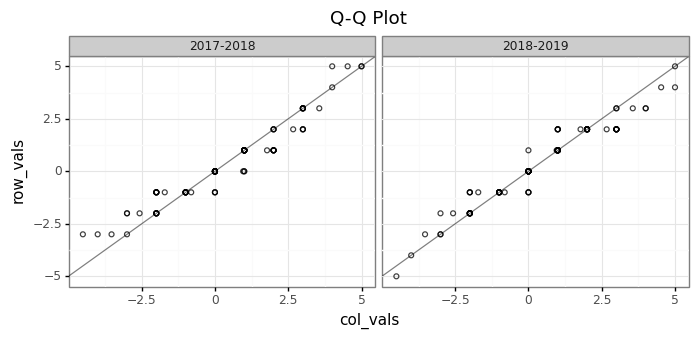

In [34]:
p = (ggplot(pairs_df2, aes(x='col_vals', y='row_vals')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(intercept=0, slope=1, alpha=0.5) +
     # coord_cartesian(xlim=(qq.min().min(), qq.max().max()), ylim=(qq.min().min(), qq.max().max())) +  
     # xlab("none") +
     # ylab("Bass 2 height (inches)") +
     labs(title="Q-Q Plot",
           caption='2.5 The height distributions are compared by q-q plots for all pairs of singer voice parts.') +
     theme_bw() +
     # theme(axis.title.x=element_blank()) +
     # labs(x="Height (inches)") + 
     # labs(y="Height (inches)") +
     facet_wrap('season', as_table=True) +
     theme(figure_size=(8,3)))

p.draw();

In [35]:
pairs3 = pd.DataFrame([('2017-2018_1', '2018-2019_1')])
pairs3.columns = ['row', 'col']
pairs_df3 = pairs3.merge(right=qq_pairs, on=['row', 'col'], how='left')
pairs_df3['season'] = pairs_df3['row'].str.split('_').str[0]
# pairs_df2['season'] = pairs_df2['row']
# pairs_dfs = []
# for pair in pairs:
#     qq_pairs.groupby(by=pair
pairs_df3

,row,col,col_vals,row_vals,season
0,2017-2018_1,2018-2019_1,-4.505435,-3.0,2017-2018
1,2017-2018_1,2018-2019_1,-3.516304,-3.0,2017-2018
2,2017-2018_1,2018-2019_1,-3.000000,-3.0,2017-2018
3,2017-2018_1,2018-2019_1,-3.000000,-3.0,2017-2018
4,2017-2018_1,2018-2019_1,-2.548913,-2.0,2017-2018
...,...,...,...,...,...
87,2017-2018_1,2018-2019_1,3.000000,4.0,2017-2018
88,2017-2018_1,2018-2019_1,3.000000,5.0,2017-2018
89,2017-2018_1,2018-2019_1,3.527174,5.0,2017-2018
90,2017-2018_1,2018-2019_1,4.000000,5.0,2017-2018


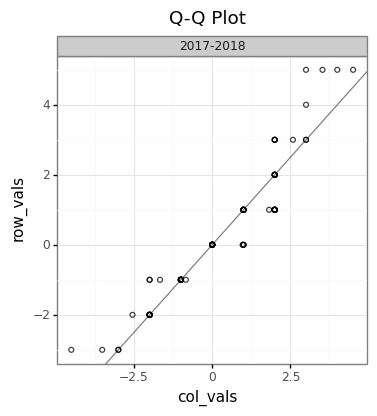

In [36]:
p = (ggplot(pairs_df3, aes(x='col_vals', y='row_vals')) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(intercept=0, slope=1, alpha=0.5) +
     # coord_cartesian(xlim=(qq.min().min(), qq.max().max()), ylim=(qq.min().min(), qq.max().max())) +  
     # xlab("none") +
     # ylab("Bass 2 height (inches)") +
     labs(title="Q-Q Plot",
           caption='2.5 The height distributions are compared by q-q plots for all pairs of singer voice parts.') +
     theme_bw() +
     # theme(axis.title.x=element_blank()) +
     # labs(x="Height (inches)") + 
     # labs(y="Height (inches)") +
     facet_wrap('season', as_table=True) +
     theme(figure_size=(4,4)))

p.draw();

## Model

In [37]:
df_2019 = df_orig.copy()
df_2019 = df_2019[df_2019['season_key']=='2019-2020']
df_2019

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,attendance,season_key,pc(hwin),pc(draw),pc(awin),result,h_points,a_points,is_covid,season_split,ha_xg,ha_xg2,ha_points,ha_goals,xg_diff,points_diff,goal_diff
760,760,1,2019-08-09,20:00,Liverpool,4.0,1.8,Norwich-City,1.0,0.9,53333.0,2019-2020,0.856623,0.093629,0.049748,hwin,3,0,0,2019-2020_0,0.666667,0.333333,1.0,0.80,0.9,3,3.0
761,761,1,2019-08-10,12:30,West-Ham,0.0,1.1,Manchester-City,5.0,3.2,59870.0,2019-2020,0.087633,0.145749,0.766618,awin,0,3,0,2019-2020_0,0.255814,-0.488372,0.0,0.00,-2.1,-3,-5.0
762,762,1,2019-08-10,15:00,Bournemouth,1.0,1.3,Sheffield-Utd,1.0,1.3,10714.0,2019-2020,0.493293,0.266136,0.240571,draw,1,1,0,2019-2020_0,0.500000,0.000000,0.5,0.50,0.0,0,0.0
763,763,1,2019-08-10,15:00,Burnley,3.0,0.9,Southampton,0.0,1.2,19784.0,2019-2020,0.359194,0.305146,0.335660,hwin,3,0,0,2019-2020_0,0.428571,-0.142857,1.0,1.00,-0.3,3,3.0
764,764,1,2019-08-10,15:00,Crystal-Palace,0.0,0.9,Everton,0.0,1.1,25151.0,2019-2020,0.288901,0.282202,0.428897,draw,1,1,0,2019-2020_0,0.450000,-0.100000,0.5,0.00,-0.2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,1135,38,2020-07-26,16:00,Leicester-City,0.0,0.8,Manchester-Utd,2.0,1.3,0.0,2019-2020,0.258780,0.266579,0.474641,awin,0,3,1,2019-2020_1,0.380952,-0.238095,0.0,0.00,-0.5,-3,-2.0
1136,1136,38,2020-07-26,16:00,Manchester-City,5.0,3.2,Norwich-City,0.0,1.0,0.0,2019-2020,0.924572,0.051976,0.023453,hwin,3,0,1,2019-2020_1,0.761905,0.523810,1.0,1.00,2.2,3,5.0
1137,1137,38,2020-07-26,16:00,Newcastle-Utd,1.0,0.1,Liverpool,3.0,0.6,0.0,2019-2020,0.178459,0.209361,0.612181,awin,0,3,1,2019-2020_1,0.142857,-0.714286,0.0,0.25,-0.5,-3,-2.0
1138,1138,38,2020-07-26,16:00,Southampton,3.0,1.7,Sheffield-Utd,1.0,1.4,0.0,2019-2020,0.487238,0.264803,0.247958,hwin,3,0,1,2019-2020_1,0.548387,0.096774,1.0,0.75,0.3,3,2.0


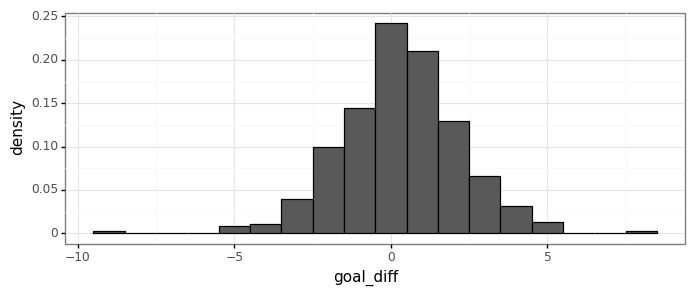

In [38]:
binwidth = 1.0
p = (ggplot(df_2019, aes(x=target_metric, y=after_stat('density'), group='season_key')) +
     geom_histogram(binwidth=binwidth, color='black') +
     # facet_wrap(facets='season_key', nrow=1, ncol=3) +
     xlab(f'{target_metric}') +
     theme(figure_size=(8, 3))
    )
p.draw();

In [39]:
# h_xg model
# target = 'h_xg'
with pm.Model() as model:
    
    # Prior distributions
    mean_common = pm.Uniform("mean_common", -1.0, 1.0)
    stdev_common =pm.Uniform("stdev_common", 0.0, 1.0)   
    
    before = pm.Normal('before', mean_common, stdev_common)
    after = pm.Normal('after', mean_common, stdev_common)
    
    # Matches change from fuuil to zero attendance at match 288
    tau = 288
    
    idx = np.arange(len(df_2019))

    switcher = pm.math.switch(tau > idx, before, after)
    
    observation = pm.Normal(target_metric, switcher, observed=df_2019[target_metric].values)
    # pm.N

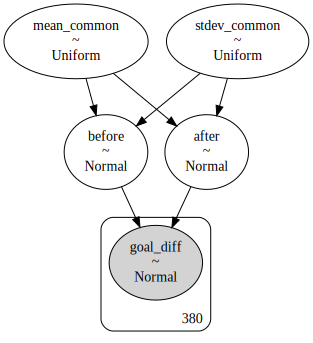

In [40]:
pm.model_to_graphviz(model)

In [41]:
with model:
    prior = pm.sample_prior_predictive(1000)

In [42]:
prior.keys()

dict_keys(['mean_common', 'mean_common_interval__', 'stdev_common', 'before', 'goal_diff', 'after', 'stdev_common_interval__'])

In [43]:
# prior_df = pd.DataFrame(prior)
# prior_df

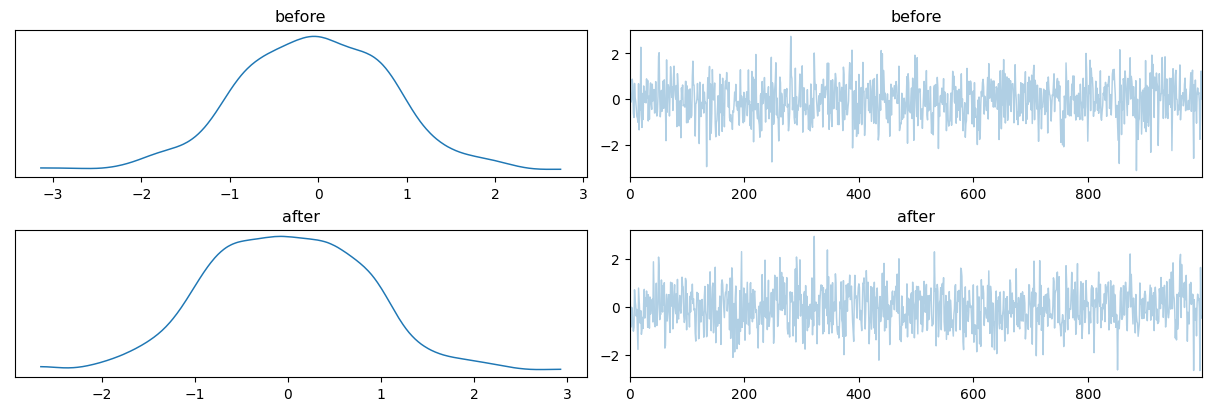

In [44]:
# Cannot understand these warnings - review later
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.plot_trace(prior, ['before', 'after'])
    plt.show()

In [45]:
az.summary(prior, kind="stats", round_to=2)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (1000) than draws (380). Passed array should have shape (chains, draws, *shape)


,mean,sd,hdi_3%,hdi_97%
mean_common,NaN,NaN,-1.00,NaN
mean_common_interval__,NaN,NaN,-6.44,NaN
stdev_common,NaN,NaN,0.00,NaN
before,NaN,NaN,-3.14,NaN
goal_diff,NaN,NaN,-6.07,NaN
after,NaN,NaN,-2.66,NaN
stdev_common_interval__,NaN,NaN,-7.82,NaN


In [46]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)
trace.report.ok

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [after]
>Metropolis: [before]
>Metropolis: [stdev_common]
>Metropolis: [mean_common]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 7 seconds.
The number of effective samples is smaller than 10% for some parameters.


False

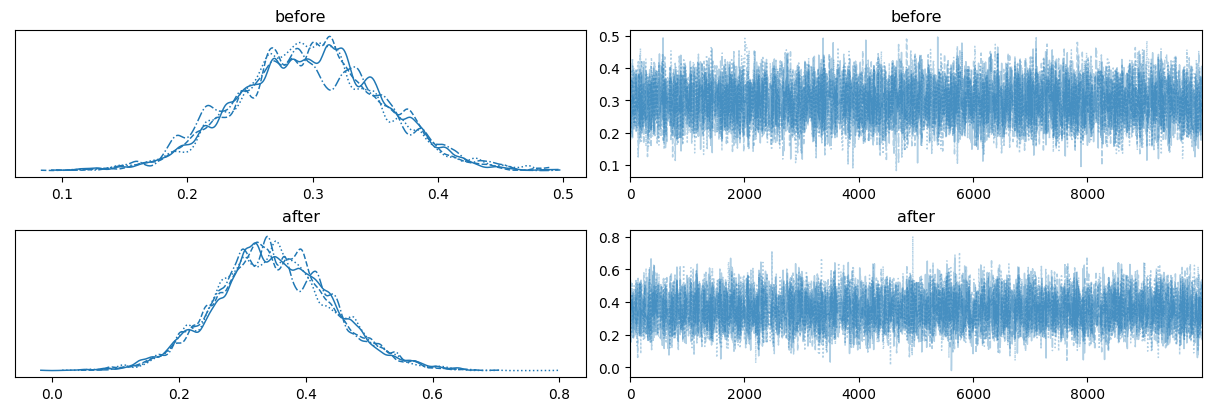

In [47]:
with model:
    pm.plot_trace(trace, ['before', 'after'])
    plt.show()

In [48]:
az.summary(trace, kind="stats", round_to=2)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


,mean,sd,hdi_3%,hdi_97%
before,0.30,0.06,0.19,0.41
after,0.35,0.09,0.18,0.53
mean_common,0.31,0.24,-0.17,0.83
stdev_common,0.28,0.25,0.00,0.78


In [49]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [after]
>Metropolis: [before]
>Metropolis: [stdev_common]
>Metropolis: [mean_common]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 7 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [50]:
# trace.ok

### Predicted Data

In [51]:
n_samples = 20000
with model:
    idata = pm.sample(n_samples, tune=20000, return_inferencedata=True)
    pred_data = pm.sample_posterior_predictive(idata, n_samples, model)[target_metric]
pred_data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [after, before, stdev_common, mean_common]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 41 seconds.
There were 4812 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5951497782840589, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2806 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4647 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6386553991063999, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4224 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6459055037597076, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/home/david/mambafo

array([[-0.89934546, -0.08356154,  0.67184952, ..., -1.86497386,
         1.03553378, -0.21921311],
       [ 0.4795336 ,  0.07756697, -1.20493922, ..., -0.10734036,
         0.05850663,  0.44010891],
       [ 0.54275533,  0.43828948, -0.47067108, ...,  0.76775362,
         0.32004163, -0.24826301],
       ...,
       [ 0.97957172, -0.34945055,  0.38188275, ...,  0.61273637,
         0.26255042, -1.37231407],
       [-0.5113099 , -1.13014723,  0.53553086, ..., -0.60755909,
        -0.56465718,  0.8435089 ],
       [ 1.03804467,  0.93174846, -1.23859471, ..., -1.16145183,
        -0.74753276, -0.74185613]])

In [52]:
pred_data.shape

(20000, 380)

In [53]:
pred_data_df = pd.melt(pd.DataFrame(pred_data.T), var_name='sample_num', value_name=target_metric)
pred_data_df['match'] = list(range(0, 380))*n_samples
pred_data_df['is_covid'] = np.array([[0]*288 + [1]*92]*n_samples).flatten()
pred_data_df

,sample_num,goal_diff,match,is_covid
0,0,-0.899345,0,0
1,0,-0.083562,1,0
2,0,0.671850,2,0
3,0,-0.275398,3,0
4,0,0.979593,4,0
...,...,...,...,...
7599995,19999,-0.040687,375,1
7599996,19999,-0.995449,376,1
7599997,19999,-1.161452,377,1
7599998,19999,-0.747533,378,1


In [54]:
diffs = []
# for sample_num, sample_df in pred_data_df.groupby(by='sample_num'):
means = pred_data_df.groupby(by=['sample_num', 'is_covid'])[target_metric].mean().reset_index()
means = means.pivot(index='sample_num', columns='is_covid', values=target_metric)
means['covid_diff'] = means[0] - means[1]
means

is_covid,0,1,covid_diff
sample_num,,,
0,0.209679,0.401322,-0.191643
1,0.268999,0.512231,-0.243232
2,0.227232,0.253449,-0.026217
3,0.257628,0.417415,-0.159787
4,0.290614,0.660203,-0.369589
...,...,...,...
19995,0.254265,0.247022,0.007243
19996,0.177864,0.210583,-0.032719
19997,0.290557,0.476096,-0.185539


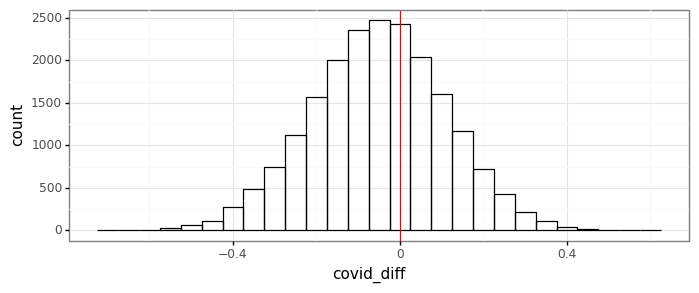

In [55]:
# df_2017[y] = stats.boxcox(df_2017[y].values, 1.5)
binwidth = 0.05
p = (ggplot(means, aes('covid_diff')) +
     geom_histogram(binwidth=binwidth, color='black', fill='none') +
     geom_vline(xintercept=0, color='red') +
     # facet_wrap(facets='season_key', nrow=1, ncol=3) +
     # xlab('proba') +
     theme(figure_size=(8, 3))
    )
p.draw();

In [56]:
(means['covid_diff'] < 0).sum() / len(means)

0.62275

+ The probability that goal difference has decreased is 0.64 (?)